# Goal of this notebook
For each row, compute a vector of cluster assigments (`Pr[view_cluster = x | row, model)]` for each model in an ensemble. This creates a long vector for each row.

Use hierarchical clustering on these vectors to cluster the rows.


In [1]:
import edn_format
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sppl.compilers.spe_to_dict as spe_to_dict

from multiprocessing import Pool
from scipy.cluster.hierarchy import dendrogram, linkage
from sppl.transforms import Identity as I

In [2]:
# Load ensemble.
with open("../data/sppl/merged.json", "r") as f:
    ensemble = spe_to_dict.spe_from_dict(json.load(f))
# Record the number of models in the ensemble.
n_models = len(ensemble.children)

In [3]:
# Load probability of dependence. We'll use this to tune number
with open("../data/dep-prob.json", "r") as f:
    dep_prob = json.load(f)

In [4]:
# Load ASTs to look up the context of a variable.
def get_ast(i):
    """Reads i-th AST from disk."""
    with open(f"../data/ast/sample.{i}.edn", "r") as f:
        ast = edn_format.loads(f.read())
    return ast
asts = [get_ast(i) for i in range(n_models)]

In [7]:
def predictors(m, context):
    """Find the top m dependent columns for a context variable"""
    return [k for k,v in sorted(dep_prob[context].items(), key=lambda item: item[1])][0:m]

In [10]:
n = 1000
context = "vaccination_status"
covariates = predictors(5, context)

In [11]:
# Generate a bunch of synthetic data rows
rows = ensemble.sample_subset([I(c) for c in covariates], n)

In [19]:
def get_view(model_index, context):
    """Get the view-ID for the `context` variable"""
    for vid, v in enumerate(asts[model_index][edn_format.Keyword("multimixture/views")]):
        if context in dict(v[edn_format.Keyword("view/clusters")][0][edn_format.Keyword("cluster/column->distribution")]).keys():
            length = len(v[edn_format.Keyword("view/clusters")])
            return vid, length


In [24]:
def prep_models(context):
    """Prepare models to create a vector of cluster assignments."""
    models = []
    for model_index in range(n_models):
        vid, length = get_view(model_index, context)
        cluster_models = []
        for cid in range(length):
            # Take only the first 10 clusters to save time.
            if cid < 10:
                try:
                    cluster_models.append(ensemble.children[model_index].constrain({I(f"view_{vid}_cluster"):str(cid)}))
                except:
                    # Print when the probability of the above is zero. Not sure why that happens
                    print(f"Problem occurred when conditioning model {model_index}, view {vid} = {cid}")
        models.extend(cluster_models)
    return models

In [25]:
models = prep_models(context)

Problem occurred when conditioning model 3, view 1 = 2
Problem occurred when conditioning model 3, view 1 = 3
Problem occurred when conditioning model 3, view 1 = 4
Problem occurred when conditioning model 3, view 1 = 5
Problem occurred when conditioning model 3, view 1 = 6
Problem occurred when conditioning model 3, view 1 = 7
Problem occurred when conditioning model 3, view 1 = 8
Problem occurred when conditioning model 3, view 1 = 9


In [27]:
def get_p(model_index):
    """Score a row for a particular cluster"""
    cluster_model = models[model_index]
    return [
        cluster_model.logpdf(row)
        for row in rows        
    ]

In [29]:
# Parallelize the scoring.
with Pool() as P:
    data = list(P.map(get_p, range(len(models))))

In [30]:
# Process the data for the hierarchical clustering.
linkage_data_input = []
for rowid in range(len(data[0])):
    r_t = []
    for md in range(len(data)):
        r_t.append(data[md][rowid])
    linkage_data_input.append(tuple(r_t))

[]

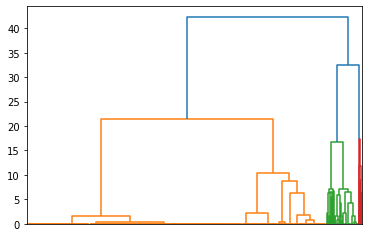

In [31]:
linkage_data = linkage(linkage_data_input, method='centroid', metric='euclidean')
dendrogram(linkage_data)
ax = plt.gca()
ax.set_xticks([])

In [32]:
def extract_clusters(linkage_matrix, level_from_top):
    level = linkage_data.shape[0] - level_from_top
    # Initial clusters
    clusters = {i: [i] for i in range(linkage_matrix.shape[0] + 1)}

    # Go through the first "level" merges
    for i in range(level):
        merged_clusters = clusters.pop(linkage_matrix[i, 0])
        merged_clusters.extend(clusters.pop(linkage_matrix[i, 1]))
        clusters[linkage_matrix.shape[0] + 1 + i] = merged_clusters

    return clusters

In [33]:
clusters = extract_clusters(linkage_data, 4)

In [34]:
def get_rowids(i):
    cluster_id = list(clusters.keys())[i]
    return clusters[cluster_id]

In [35]:
df = pd.DataFrame(rows)
df = df.rename(columns={c:c.__str__() for c in rows[0].keys()})

In [ ]:
def show_typical_vals(i):
    """Show typical vals for consensus cluster."""
    for c in df.columns:
        if c != 'Games_Board_Puzzles':
            print(c)
            format("Median", df.loc[get_rowids(i),c].median())
            format("Standard deviation", df.loc[get_rowids(i),c].std())

In [ ]:
show_typical_vals(0)

In [ ]:
show_typical_vals(1)

In [ ]:
show_typical_vals(2)